# Adaptive PDE discretizations on cartesian grids 
## Volume : Algorithmic tools
## Chapter : The monopolist problem

We present numerical methods meant to address optimization problems posed on the set of *convex functions*.
These methods are applied to the monopolist problem, described below and arising from theoretical economics, which reads: 
$$
    \max_u \int_X (<x,\nabla u(x)> - u(x) - C(\nabla u(x))) \rho(x) dx,
$$
where $\rho$ is a non-negative density over a domain $X$, and $C$ is a convex cost function. This optimization problem is subject to the following constraints:
$$
    u \text{ convex, non-negative, and } \nabla u(x) \in Y \text{ a.e. } x \in X,
$$
where $Y$ is a given convex domain. 

We briefly describe the economic interpretation of this problem in a first section, and then present some numerical experiments in dimension one and two.

<!--- 
on a convex set $X\subset R^d$., whose gradient is possibly contrained within another convex set $Y\subset R^d$. 
--->


[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Introduction](#1.-Introduction)
    * [1.1 A convex barrier for convex functions](#1.1-A-convex-barrier-for-convex-functions)
    * [1.2 The monopolist problem](#1.2-The-monopolist-problem)
  * [2. The one dimensional monopolist problem](#2.-The-one-dimensional-monopolist-problem)
    * [2.1 Quadratic production costs](#2.1-Quadratic-production-costs)
    * [2.2 Null costs within a bounded product range](#2.2-Null-costs-within-a-bounded-product-range)
  * [3. Two dimensional, quadratic, monopolist](#3.-Two-dimensional,-quadratic,-monopolist)
    * [3.1 Finite element discretization of the energy](#3.1-Finite-element-discretization-of-the-energy)
    * [3.2 Subgradient measures of a piecewise linear function](#3.2-Subgradient-measures-of-a-piecewise-linear-function)
    * [3.3 Optimization, uniformly convex domain](#3.3-Optimization,-uniformly-convex-domain)
    * [3.4 Non-uniformly convex domain](#3.4-Non-uniformly-convex-domain)
  * [4. Two dimensional, linear, monopolist](#4.-Two-dimensional,-linear,-monopolist)
    * [4.1 Finite element approach](#4.1-Finite-element-approach)
    * [4.2 Intersected subgradient approach (*TODO*)](#4.2-Intersected-subgradient-approach-(*TODO*))



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans, 
and PhD student François Desquilbet, in co-direction with Ludovic Métivier.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Monopolist','Algo'))

In [2]:
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import scipy
import scipy.optimize as sciopt
from matplotlib import pyplot as plt

In [4]:
from agd.ExportedCode.Notebooks_Algo.Meissner import LinearConstraint_AD,QuadraticObjective_AD

## 1. Introduction

### 1.1 A convex barrier for convex functions


We present numerical methods meant to address optimization problems posed on the set of convex functions, defined over a convex set $X\subset R^d$, and whose gradient is almost everywhere constrained within another convex set $Y\subset R^d$. 
$$
    \mathrm{Conv}(X;Y) := \{u : X \to R; u \text{ convex}, \nabla u(x) \in Y\ a.e.\ x \in X\}
$$
We provide a discrete counterpart of this set, defined in terms of a family of constraints, which are non-linear in dimension $d\geq 2$. As discussed below, the corresponding barrier function is convex, and admits an interpretation of it as an entropy.


**Discrete convexity constraints.**
Let $X\subset R^d$ be a set, possibly finite (in constrast with the previous paragraph). Let $u : X \to R$, and for each $x \in X$ let 
$$
    \partial_x u := \{v \in R^d; \forall y \in X, u(y)-u(x) \geq <v,y-x>\}
$$
denote the subgradient of $u$ at $x$. In this context we define
$$
    \mathrm{Conv}(X;Y) := \{u : X \to R; \forall x \in X,\ Y \cap \partial_x u \neq \emptyset\}.
$$
The following remarks are in order:
- If $X$ is a convex set, then the above two definitions of $\mathrm{Conv}(X;Y)$ are compatible. 
- If $\tilde X := \mathrm{Hull}(X)$ is the convex hull of $X$, then $\mathrm{Conv}(X;Y) \subset \mathrm{Conv}(\tilde X;Y)$, where a function $u:X \to R$ is implicitly extended to $\tilde X$ by its lower convex envelope.
- If $X$ is a finite set, then only the second definition makes sense. In addition, the interior of $\mathrm{Conv}(X;Y)$ is characterized by the strict inequality constraints:
$$
    |Y \cap \partial_x u| > 0, \forall x \in X
$$

In the following, we assume that the set $X$ is finite, and denote by $\partial X := X \cap \partial \mathrm{Hull}(X)$ the subset of points lying on the boundary of its convex hull.
If $Y = R^d$, and more generally if $Y$ is unbounded, then the cells associated to points $x \in X$ can be unbounded, or empty, hence the associated constraints require a special numerical treatment.

**The barrier function.**
Constrained optimization methods based on interior points, such as `trust-constr` in `scipy.optimize.minimize`, often rely on *barrier functions* which are defined as a negative weighted sum of the logarithm of the constraints.
In our case:
$$
    S(u) := -\sum_{x \in X} \rho(x) \ln |Y \cap \partial_x u|,
$$
where $\rho : X \to [0,\infty[$ is a given collection of weights.
We limit here our discussions to the case where $Y$ is bounded, since otherwise the points $x \in \partial X$ require a special treatment, see the relevant sections of the notebook.

For efficient optimization, one expects the barrier function to be well behaved, in particular it should be (i) convex $\nabla^2 S \succ 0$, (ii) the hessian should dominate the gradient $|<\nabla S,v>| \leq C |<v,\nabla^2 S v>|^\frac 1 2$ (self consistency condition), and (iii) the hessian should dominate the third order derivatives, $|\nabla^3 S(v,v,v)| \leq 2|<v,\nabla^2 S v>|^\frac 3 2$. 
In our case, in dimension $d\geq 2$, one can check that (i) and (ii) hold, by virtue of Minkowski's inequality. In contrast whereas (iii) fails, and in fact $S$ is not but three times differentiable, that does not seem to be a major issue.

**Entropy interpretation.**
The entropy of the discrete measure defined as a Dirac mass of weight $\rho(x)$ at each position $x\in X$, and w.r.t the counting measure on these points, is defined as 
$$
    H(\rho) := \sum_{x \in X} \rho(x) \ln \rho(x).
$$

Denote by $\mu$ the density on $R^d$ which assigns a weight $\rho(x)$ to each cell $C_x := Y \cap \partial_x u$ in a uniform manner, for all $x \in X$.
Then the entropy of $\mu$, w.r.t the Lebesgue measure on its support, is 
$$
    H(\mu) = - \int_{R^d} \mu \ln \mu 
    = - \sum_{x \in X} \int_{C_x} \frac{\rho(x)}{|C_x|} \ln \frac {\rho(x)}{|C_x|}
    = - \sum_{x \in X} \rho(x) \ln \frac {\rho(x)}{|C_x|}
    = \sum_{x \in X} \rho(x) \ln |C_x| - \sum_{x \in X} \rho(x) \ln \rho(x).
$$
Therefore our barrier function is obtained as the difference between the entropy of the source measure $\rho$, and of its image measure $\mu$ by the subgradient map 
$$
    S(u) = H(\rho) - H(\mu).
$$

### 1.2 The monopolist problem

We briefly review the monopolist problem, arising in theoretical economics, and which is numerically addressed in this notebook.

Suppose a monopolist is able to produce a variety of products, whose characteristics are encoded as a point in a set $Y \subset R^d$. The monopolist is able to fix arbitrary prices
$$
    \pi : Y \to R,
$$
except for the null product, which must be avalaible for free: $\pi(0) = 0$. There is also a fixed production cost 
$$
    C : Y \to ]-\infty,\infty].
$$
The characteristics of the potential customers are encoded as a point in a set $X\subset R^d$. The utility to customer $x \in X$ of a product $y \in Y$ is modeled as the scalar product
$$
    {<}x,y>.
$$
This assumption of bi-linearity of the utility is quite strong from the modeling point of view, but bypassing it is outside of the scope of this notebook. 

Each customer scans the available products, and buys a single one (possibly the null product) which provides the best utility minus cost. This leads to the customer utility function, defined for any customer characteristics $x\in X$:
$$
    u(x) := \max_{y \in Y} <x,y> - \pi(y).
$$
By construction, this utility function is:
- *non-negative*, due to the availability of the null product $\pi(0)=0$.
- *convex* since it is the upper envelope of the family of affine functions $u_y : x\mapsto <x,y> - \pi(y)$, for all $y \in Y$.
- has a *gradient constrained within $Y$*, by the envelope theorem and since $\nabla u_y = y$ identically.

The density of customers with each given characteristic is denoted $\rho : X \to R$. The overall profit of the monopolist, obtained as the selling price minus the production cost, are thus
$$
    \int_X (\pi(y(x)) - C(y(x))) \rho(x) dx,
$$
where $y(x)$ is the product chosen by customer $x$.

Observing that $u(x) = <x,y(x)>-\pi(y(x))$, by definition, and that $y(x) = \nabla u(x)$, by the envelope theorem, we reformulate the total profit as 
$$
\int_X (<x,\nabla u(x)> - u(x) - C(\nabla u(x))) \rho(x) dx.
$$
The purpose of the monopolist is to maximize this profit, knowing $C$ and $\rho$, by adjusting the prices $\pi$.
Since the utility function $u : X \to R$ is the Legendre-Fenchel conjugate of the prices, we can use it as the unknown, and recover the prices afterwards using another Legendre-Fenchel transform.

**The quadratic costs model**, is characterized by $Y:=R^d$, $C(y) := \frac 1 2 \|y\|^2$.

Interpretation (d=2) : Suppose the product $y = (y_0,y_1)$ is a car, where $y_0$ accounts for the car performance, and $y_1$ accounts for its comfort. For simplicity these two characteristics are not a-priori bounded, as reflected by the choice $Y = R^d$, but the production cost $C(y_0,y_1) = \frac 1 2 (y_0^2+y_1^2)$ grows quadratically with them.

The monopolist profit (sales minus production costs), for the optimal product catalog, is obtained as 
$$
    \max_u \int_X (<x,\nabla u(x)> -u(x)- \frac 1 2 \|\nabla u(x)\|^2) \rho(x) dx.
$$
among *non-negative convex* functions $u : X \to R$.

**The bounded product range, null costs, model**, is characterized by $Y = [0,1]^d$, $C=0$.

Interpretation ($d=2$) : suppose the product $y = (y_0,y_1)$ is an online streaming service, where $y_0$ accounts for subscription the movies, whereas $y_1$ accounts for the subscription to sports. 
The four corners of the set $Y = [0,1]^2$ represent immediate deterministic offers, for instance $(1,0)$ represents a subscription to movies but not sports. Other points of $Y$ represent time delayed offers, or lotteries. The marginal cost of an additional customer subscription is negligible, hence the choice $C=0$.

The monopolist profit, for the optimal product catalog, is obtained as
$$
    \max_u \int_X (<x,\nabla u(x)> - u(x)) \rho(x) dx.
$$
among *non-negative convex* functions $u : X \to R$ such that $\nabla u(X) \subset [0,1]^d$.

## 2. The one dimensional monopolist problem

The one dimensional monopolist problem has been well studied and can be solved analytically, at least when the density of customer traits is constant. Nevertheless, we adopt a numerical approach as a preparation for the multi-dimensional case, and in order to illustrate some qualitative behavior. More complex and subtle behavior is obtained in higher dimension.

**Discretization** The set $X = \{x_0 < \cdots < x_{I-1}\}$ is a finite ordered sets of reals, discretizing the interval $[x_0,x_{I-1}]$.
The unknown function $u$ is known by its values $u_0,\cdots,u_{I-1}$ at these points. Our discretization relies on some midpoint averages and differences.

In [5]:
def avg(z):
    """Midpoint averages""" 
    return (z[1:]+z[:-1])/2

def diff(z): 
    """Midpoint slopes"""
    return z[1:]-z[:-1]

We choose the following domain and density.

In [6]:
nX = 51 # Number of discretization points
X = np.linspace(0,1,nX) # Domain is [0,1]
ρ = np.ones(nX-1)

A null initial guess is used for the optimization problems. First and second order automatic differentiation is used to differentiate the objective function and constraints.

In [7]:
U = np.zeros_like(X) # Initial guess
U_ad = ad.Sparse.identity(constant=U)
U_ad2 = ad.Sparse2.identity(constant=U)

### 2.1 Quadratic production costs 


**Qualitative behavior : voluntarily neglecting some potential customers.** In the quadratic cost model, the monopolist has the possibility to sell products to all clients including the poorest ones, and always make a profit out of it. However, the monopolist often willingly reduces the product catalog, and thus does not address the lower end market, in order to avoid self competition. 

**Optimization problem** The (opposite of the) monopolist profit is obtained as
$$
    \min_u \int_X (u(x)-x u'(x) + \frac 1 2 u'(x)^2) \rho(x) dx
$$
subject to $u$ convex, non-negative. 

We implement this objective function in the next cell, using finite differences.


In [8]:
def quadratic_objective(U,X,ρ):
    """
    u and X are defined at nodes,
    ρ is defined between nodes.
    """
    mX = avg(X); mU = avg(U) # Midpoint values
    dX = diff(X); dU = diff(U) # Successive differences
    g = dU / dX # Gradient at the midpoint
    
    integrand = mU - mX*g + g**2/2
    return np.sum(integrand * ρ * dX)

Recall that, for a piecewise linear one dimensional convex function, the subgradient measure at a point is obtained as the difference of the gradients (slopes) immediately before and afterwards. We impose as a constraint that these subgradients measures be positive.

In [9]:
def interior_subgradients(U,X):
    """Returns the subgradients measures of U at the interior points of X"""
    g = diff(U) / diff(X) # Gradient at the midpoint
    return diff(g) # Subgradient measure if the difference of successive gradients

The `trust-constr` interior point optimization method is used for convenience, and for generality in view of the subsequent applications.

In [10]:
sol = sciopt.minimize(x0=U,method='trust-constr',
    **QuadraticObjective_AD(quadratic_objective(U_ad2,X,ρ)),
    constraints = [LinearConstraint_AD(interior_subgradients(U_ad,X))],
    bounds = sciopt.Bounds(0.,np.inf)
                     )

Recally that $u(x)$ is the utility to customer $x$, and that $u'(x)$ is the product bought. The trait $x$ represents how much customer $x$ values the offered goods, hence it is closely related as the wealth of customer $x$. We can distinguish two behaviors:
- Poor customers buy the null product: $u(x)=0$ for sufficiently small $x$.
- Rich customers buy a product specifically designed for their characteristic: $u'$ is strictly increasing for sufficiently large $x$.

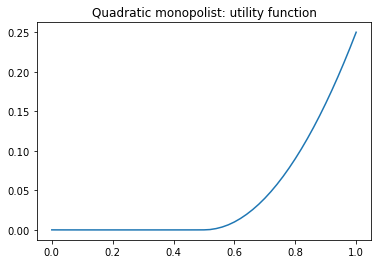

In [11]:
plt.title("Quadratic monopolist: utility function")
plt.plot(X,sol.x);

**Commented : on using the agd library (too trivial to be part of it)**

<!---
Again, we can use the `ConvexEntropy.ConvexBarrier` method, this time without the set $Y$ which is not needed.

lcons_cvx_ad = ConvexEntropy.ConvexBarrier(u_ad,X,Xbd)[1];

sol_cvx = sciopt.minimize(x0=u,method='trust-constr',
    **QuadraticObjective_AD(objective(u_ad2,ρ,X)),
    constraints = [LinearConstraint_AD(lcons_cvx_ad)],
    bounds = sciopt.Bounds(0.,np.inf)
                     )
assert np.allclose(sol.x,sol_cvx.x)
--->

### 2.2 Null costs within a bounded product range


**Qualitative behavior : extremal products only.** In principle, the monopolist may an infinite variety of products $Y = [0,1]$. However, the optimal product line only features the extremal products $0$ and $1$. In the context of a subscription service, this means that the optimal strategy does not feature any lottery or time-delayed discounted offer.



**Optimization problem.** The monopolist profit is the opposite of 
$$
    \min_u \int_X (u(x)-x u'(x)) \rho(x) dx
$$
subject to $u$ convex, non-negative, and $u'(x)\in Y := [0,1]$ for all $x \in X$. 

We implement this objective function in the next cell, using finite differences.

<!---
$u(0) = 0$, $u'(0)\geq 0$, $u'(1)\leq 1$.
--->

In [12]:
def linear_objective(U,X,ρ):
    """
    u and X are defined at nodes,
    ρ is defined between nodes.
    """
    mX = avg(X); mU = avg(U) # Midpoint values
    dX = diff(X); dU = diff(U) # Successive differences
    g = dU / dX # Gradient at the midpoint
    
    integrand = mU-mX*g
    return np.sum(integrand * ρ * dX)

We already implemented in the `interior_subgradient` map the constraint that the subgradients of $u$ at interior points of $X$ have positive measure. 
In order to enforce the additional constraint $u'(x)\in Y$ for all $x \in X$, we also consider the subgradients at the extremal points, which are unbounded, and intersect them with the set $Y:=[0,1]$.

In [13]:
Y = [0,1]

In [14]:
def boundary_subgradients(U,X,Y):
    """Returns the subgradient measures of u at the 
    extremal points of X, intersected with Y"""
    g = diff(U) / diff(X)
    return ad.array([ g[0]-Y[0], Y[-1]-g[-1] ])

The `trust-constr` interior point optimization method is again used for convenience.

In [15]:
sol = sciopt.minimize(x0=U,method='trust-constr',
    **QuadraticObjective_AD(linear_objective(U_ad2,X,ρ)),
    constraints = [LinearConstraint_AD(interior_subgradients(U_ad,X)),
                   LinearConstraint_AD(boundary_subgradients(U_ad,X,Y))],
    bounds = sciopt.Bounds(0.,np.inf)
                     )

As expected for this specific model, the utility function is piecewise affine, with only two distinct slopes, corresponding to the two following products:
- $y=0$, the null product, available for free, chosen by `poor` customers.
- $y=1$, the full product, chosen by `rich` customers.

In dimension $1$, the optimal product line for the monopolist does not feature any intermediate product $0<y<1$, such as a time delayed offer or a lottery ticket.

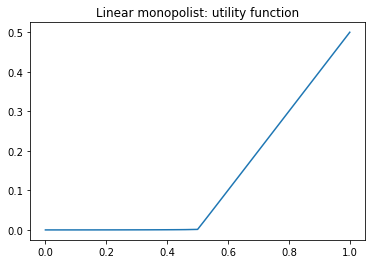

In [16]:
plt.title("Linear monopolist: utility function")
plt.plot(X,sol.x);

As announced, we can use a linear solver to achieve the same result.

In [17]:
obj_ad = linear_objective(U_ad,X,ρ).to_dense()
lcons_ad = np.concatenate([boundary_subgradients(U_ad,X,Y),interior_subgradients(U_ad,X)])

In [18]:
sol_lin = sciopt.linprog(obj_ad.gradient(), options={'sparse':True},
               A_ub = (-lcons_ad).tangent_operator(), b_ub = lcons_ad.value, 
               bounds=np.transpose([np.zeros(nX),np.full(nX,np.inf)]) )

The solution obtained with the linear the linear solver is identical... up to numerical solver error, which is not so small. 

In [19]:
assert np.allclose(sol.x,sol_lin.x,atol=2e-3) 

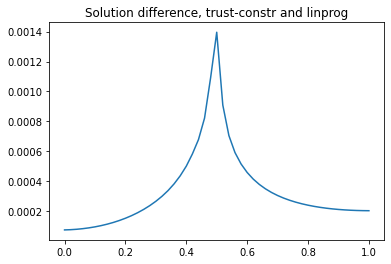

In [20]:
plt.title("Solution difference, trust-constr and linprog")
plt.plot(X,sol.x-sol_lin.x);

**Commented : Using the AGD library (seems to trivial for a proper implementation)**

<!---
Finally, let us mention that the routine `ConvexEntropy.ConvexBarrier` can take into account the target space $Y=[0,1]$ directly. Hence there is no need to impose the slope bound independently.

Xbd=np.zeros_like(X); Xbd[0]=Xbd[-1]=1 # Boundary of X
Y = [0.,1.] # Region within which the gradient is constrained
lcons_cvxY_ad = ConvexEntropy.ConvexBarrier(u_ad,X,Xbd,Y)[1];


sol_cvx = sciopt.minimize(x0=u,method='trust-constr',
    **QuadraticObjective_AD(objective(u_ad2,ρ,X)),
    constraints = [LinearConstraint_AD(lcons_cvxY_ad)],
    bounds = sciopt.Bounds(0.,np.inf)
                     )
                     
assert np.allclose(sol.x,sol_cvx.x,atol=2e-3) 
--->

## 3. Two dimensional, quadratic, monopolist 

We address the two dimensional monopolist problem, with a quadratic cost function and an otherwise unconstrained product line.

### 3.1 Finite element discretization of the energy

In contrast with most other notebooks in this repository, we use finite elements (continuous piecewise affine) to discretize the monopolist objective function.

A $d$-dimensional triangulation is presented as a pair 
$$
    (X,T)
$$
where $X \in (R^d)^N$ is a set of $N$ points, and $T\in (\{0,\cdots,N-1\}^{d+1})^M$ defines $M$ simplices by providing the indices of their $d+1$ vertices.

For simplicity, we use the *Delaunay triangulation* of a regular sampling of three basic shapes: the square, equilateral triangle, and unit disk. For reasons discussed later, it will be important to know the *non-strictly convex faces* of these domains. 

**Hidden boundary routine**

<!---
def Boundary(X,l=[1,1]):
    """Returns the boundary of X (indices), trigonometrically ordered, 
    starting with the extremal point in the direction of l"""
    delaunay=scipy.spatial.Delaunay(X.T)
    DX = np.unique(delaunay.convex_hull.reshape(-1)) # Boundary points
    mX = np.mean(X[:,DX],axis=1) # Some interior point
    DX = DX[np.argsort( np.angle((X[0,DX]-mX[0]) + 1j*(X[1,DX]-mX[1])) )]
    DX = np.roll(DX,-np.argmax(X[0,DX]*l[0]+X[1,DX]*l[1]))
    return DX
--->

In [21]:
def square_X(n):
    """A regular sampling of the unit square, approx n^2 points."""
    aX = np.linspace(0,1,n+1)
    X = np.array(np.meshgrid(aX,aX,indexing='ij')).reshape(2,-1)
    tol = 0.5/n
    return X, (X[0]>1-tol,X[1]>1-tol,X[0]<tol,X[1]<tol)

def triangle_X(n):
    """A regular sampling of the equailateral triangle of vertices 
    (1,0), (-1/2,sqrt 3/2),(-1/2,-sqrt 3/2), approx n^2/2 points"""
    X = np.array([ (i/n,j/n) for i in range(n+1) for j in range(n-i+1)]).T
    tol = 0.5/n
    def aff(X): return np.array([1-(X[0]+X[1])*3/2, (X[1]-X[0])*np.sqrt(3)/2])
    return aff(X), (X[0]+X[1]>1-tol,X[0]<tol,X[1]<tol)

def disk_X(n):
    """A regular sampling of the unit disc, approx π n^2 points"""
    τ = 2*np.pi
    X = np.array([ (i*np.cos(θ),i*np.sin(θ)) for i in range(n+1) 
        for θ in np.linspace(0,τ,np.maximum(1,int(τ*i)),endpoint=False)]).T/n
    return X,tuple() # No facet : the disk is uniformly convex

In [22]:
def Delaunay(X): return scipy.spatial.Delaunay(X.T).simplices.T

In [23]:
def show_X(X,DX):
    plt.triplot(*X,Delaunay(X).T)
    for F in DX: plt.scatter(*X[:,F])
    plt.axis('equal')

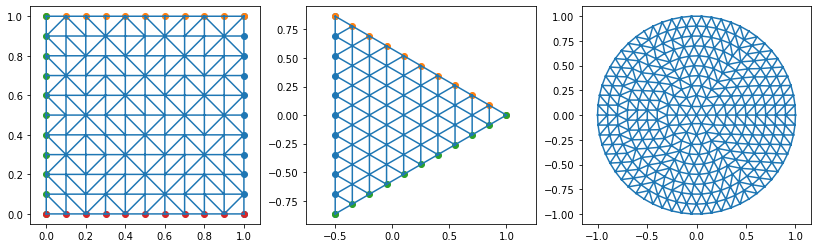

In [24]:
plt.figure(figsize=(14,4))
plt.subplot(131); show_X(*square_X(10))
plt.subplot(132);show_X(*triangle_X(10))
plt.subplot(133); show_X(*disk_X(10))

Following a standard finite element approach, we compute the gradient and mean on each simplex of a given piecewise linear function.

In [25]:
def gradientFE(u,X,T):
    """Gradient on each simplex of the piecewise affine function u"""
    A = [ X[:,T[1]]-X[:,T[0]], X[:,T[2]]-X[:,T[0]] ]
    return lp.solve_AV(A,u[T[1:]]-u[T[0]])

In [26]:
X,_ = disk_X(10)
assert np.allclose(gradientFE(X[0]+2*X[1],X,Delaunay(X)),[[1],[2]])

In [27]:
def meanFE(u,T):
    """Mean on each simplex of piecewise affine function u"""
    return np.mean(u[...,T],axis=-2)

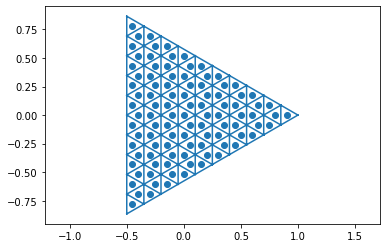

In [28]:
X,_ = triangle_X(10)
plt.scatter(*meanFE(X,Delaunay(X)))
plt.triplot(*X,Delaunay(X).T); plt.axis('equal');

In [29]:
def cellmeasFE(X,T):
    """Area (or volume) of each simplex in the triangulation"""
    return lp.det(X[:,T[1:]]-X[:,None,T[0]])/np.math.factorial(len(X))

In [30]:
nX=10
X,_ = square_X(nX); 
assert np.allclose(cellmeasFE(X, Delaunay(X)), 0.5/nX**2)
X,_ = triangle_X(10); 
assert np.allclose(cellmeasFE(X, Delaunay(X)),3*np.sqrt(3)/4/nX**2)

Finally, we discretize the objective functional 
$$
    \int_\Omega (u(z) - <z,\nabla u(z)> + \frac 1 2 \| \nabla u(z)\|^2) \rho(z) dz,
$$
possibly omitting the quadratic term. Note that this functional is quadratic.

In [31]:
def monopolist_objective(u,X,T,ρ=1.,quadratic=True):
    g = gradientFE(u,X,T)
    integrand = meanFE(u,T) - lp.dot_VV(meanFE(X,T),g) # u(z) - <grad u(z),z>
    if quadratic: integrand += lp.dot_VV(g,g)/2 # + |grad u(z)|^2 /2
    return np.sum(integrand*cellmeasFE(X,T)*ρ)

### 3.2 Subgradient measures of a piecewise linear function

The following code computes the subgradients measures of a function $u:X \to R$ defined over a finite set $X$. The pseudo-code of this routine is as follows:
* Compute the convex envelope of the set 
$$
    \{(x,u(x)); x \in X\}
$$
which defines a triangulated surface $S$ in $R^3$.
* Remove all the triangles of $S$ whose normal vector does not point downwards.
What is left is the graph of a function, denoted as 
$$
    \{(x,\tilde u(x)); x \in \mathrm{Hull}(X)\},
$$
and $\tilde u$ is *piecewise linear and convex* over a triangulation $\cal T$ of the set $X$.
Note that $\tilde u(x) = u(x)$ for all $x\in X$, if $u$ admits any convex extension.
* Compute the gradient of $\nabla \tilde u$ on each triangle of $T\in \cal T$, denoted as $g_T$.
* Denote by $\mathrm{int}(X) := X \setminus \partial \mathrm{Hull}(X)$ the finite set of interior points of $X$.

Recall that our objective is to compute, for each $x \in \mathrm{int}(X)$, the area of 
$$
    |\partial_x u| = \mathrm{Hull}\{g_T; T \in \cal T, x \in T\}.
$$
Denote by $T_1,...,T_I \in \cal T$ the triangles containing $x$ and oriented counter-clockwise around $x$. Then the polygon $|\partial_x u|$ can be decomposed as a union of triangles, and its area computed, as follows
$$
    |\partial_x u| = \sum_{1 \leq i \leq I} |\mathrm{Hull}\{g_{T_i}, g_{T_{i+1}}, g_x\}|,
$$
where $g_x$ is any point of $\partial_x u$. The pseudo-code for the rest of the function is thus.

* For each $x \in \mathrm{int}(X)$, find an arbitrary but fixed triangle $T(x)\in \cal T$ containing $x$, and define $g_x = g_{T_x}$. (The AD information within $g_x$ can be removed here, since this gradient only serves as an arbitrary element of $\partial_x u$.)
* For each triangle $T \in \cal T$, and each vertex $x$ of $T$, find the triangle $T' \in \cal T$ counter-clockwise around $x$. Compute the area contribution of $|\mathrm{Hull}\{g_{T}, g_{T'}, g_x\}|$ to the subgradient area $|\partial_x u|$.

In [32]:
def FacetGradients(u,X,tol_bd=1e-6):
    """
    Computes the convex hull of the graph of u. 
    Returns  
        - S : the facets, triplets of vertices, oriented counter-clockwise
        - N : the facet neighbors
        - Sint : which facets are interior
        - Sg : the gradient on each facet
    """
    # The graph of the function u, with all AD information removed
    u = u.reshape(-1); X = X.reshape(2,-1)
    graph = np.append(ad.remove_ad(X),ad.remove_ad(u)[None],axis=0) 
    hull = ConvexHull(graph.T) # Key geometric step

    if len(hull.vertices)!=u.size: # Then hull.vertices == np.arange(u.size)
        raise ValueError("Non convex function : empty subgradients at ",set(range(u.size))-set(hull.vertices))

    # Variables naming convention : 
    # - S... data attached to simplices, 
    # - X... data attached to vertices
    # - N... data attached to neighbor vertices

    # Orient the simplices counter-clockwise
    S = hull.simplices.T     
    N = hull.neighbors.T
    cw = np.sign(lp.det(X[:,S[1:]]-X[:,S[0,None]]))==-1
    S[1,cw],S[2,cw] = S[2,cw],S[1,cw] 
    N[1,cw],N[2,cw] = N[2,cw],N[1,cw] 

    # Find simplices which do not correspond to the lower convex hull
    Sbd = hull.equations[:,2] >= -tol_bd # Boundary simplices safe to omit
    Sint = ~Sbd # Interior simplices
    
    # Compute the gradient associated to each facet, excluding boundary facets
    Sdu = u[S[1:]]-u[S[0]]              # Value differences, for each simplex
    SdX = X[:,S[1:]]-X[:,S[0,None]]     # Vertex differences, for each simplex

    Sdu[:,Sbd]   = np.nan 
    SdX[:,:,Sbd] = np.nan # Erase boundary simplices, to avoid zero divide

    Sg = lp.solve_AV(lp.transpose(SdX),Sdu) # Gradient of u on each simplex

    return S,N,Sint,Sg

def SubgradientMeasures(S,N,Sint,Sg,Sbd=np.nan):
    """Compute the subgradient measures of a convex functions, 
    at the interior points of a domain. Sbd : value to put in boundary cells."""
    
    # Choose a reference simplex for each vertex, and thus a reference point in each cell
    XS = np.full(np.max(S)+1,-1,S.dtype)
    XS[S[:,Sint]] = np.arange(S.shape[1],dtype=S.dtype)[None,Sint] # Ref simplex per vertex
    Xg = ad.remove_ad(Sg)[:,XS]    # Reference gradient for each vertex

    Ng = Sg[:,N] # Gradients for the neighbor cells
    Srg = Xg[:,S] # Reference gradient associated to each vertex of the simplex 

    # Compute the contribution of the simplex and its neighbor to the subgradient measure
    Sm = lp.det([Sg[:,None]-Srg,np.roll(Ng,-1,axis=1)-Srg])/2
    S = S.reshape(-1); Sm = ad.simplify_ad(Sm.reshape(-1))
    
    # Put desired value in boundary subgadient cells
    Xbd = (np.bincount(S,np.isnan(Sm))>0)*np.bincount(S)
    bd = Xbd[S]
    Sm[bd>0]=Sbd/bd[bd>0]
    
    return S,Sm

As a validity test, we check the subgradient measures of quadratic function sampled over a Cartesian grid, in dimension $d=2$.
Define the square grid 
$$
X = \{-n,\cdots, 0,1,\cdots,n\}^d,
$$ 
and the quadratic function 
$$
u(x) := \frac 1 2 <x,Ax> + <b,x> +c,
%x^\top \cdot A \cdot x + b^\top \cdot x
$$
where $A\in S_d^{++}$, $b \in R^d$, and $c \in R$.
Then 
$\nabla u(x) = A x+ b$ is affine, and thus maps $X$ to another lattice.
The subgradient cells $\partial_x u$, for $x \in X$ sufficiently far from the boundary, all have the same area 
$$
    |C_x| = \det A
$$
which is the determinant of the image lattice.

In [33]:
def quadratic_grid_test(quad,n):
    """Compare the subgradient measures with the quadratic form determinant.
    (Expected to match in the interior.)"""
    aX = np.linspace(-n,n,2*n+1)
    X = np.array(np.meshgrid(aX,aX,indexing='ij'))
    
    S,Sm = SubgradientMeasures(*FacetGradients(quad(X),X))
    meas = np.bincount(S,Sm).reshape(X.shape[1:])
    
    x_ad = ad.Dense2.identity(constant=[0.,0.])
    A = quad(x_ad).coef2
    
    return meas,np.linalg.det(A)

Choosing $A=\mathrm{Id}$, all subgradient associated to non-boundary points cells are square, and have unit area, as expected.

In [34]:
def quad0(X): return 0.5*(X[0]**2+X[1]**2) + X[1]-2
quadratic_grid_test(quad0,3)

(array([[nan, nan, nan, nan, nan, nan, nan],
        [nan,  1.,  1.,  1.,  1.,  1., nan],
        [nan,  1.,  1.,  1.,  1.,  1., nan],
        [nan,  1.,  1.,  1.,  1.,  1., nan],
        [nan,  1.,  1.,  1.,  1.,  1., nan],
        [nan,  1.,  1.,  1.,  1.,  1., nan],
        [nan, nan, nan, nan, nan, nan, nan]]),
 1.0)

Choosing some anisotropic matrix $A$, we see that only cells sufficiently far from the boundary have unit area.

In [35]:
def quad1(X): return 0.5*(X[0]**2-3*X[0]*X[1]+3*X[1]**2) 
quadratic_grid_test(quad1,3)

(array([[  nan,   nan,   nan,   nan,   nan,   nan,   nan],
        [  nan, 0.875, 0.875, 0.875, 0.875, 0.875,   nan],
        [  nan, 0.75 , 0.75 , 0.75 , 0.75 , 0.75 ,   nan],
        [  nan, 0.75 , 0.75 , 0.75 , 0.75 , 0.75 ,   nan],
        [  nan, 0.75 , 0.75 , 0.75 , 0.75 , 0.75 ,   nan],
        [  nan, 0.875, 0.875, 0.875, 0.875, 0.875,   nan],
        [  nan,   nan,   nan,   nan,   nan,   nan,   nan]]),
 0.75)

### 3.3 Optimization, uniformly convex domain

For reasons unclear to us, the scipy optimizer `trust-constr` does not appear to like this problem.
Indeed, it is likely quite stiff, but on the other hand it is convex. For this reason, we implement by ourselves the logarithmic barriers and penalized objective function.

**Case of a uniformly convex domain.**
When the discretized domain is uniformly convex, as in the case of a disk, the subgradient measures of the boundary points are guaranteed to be $+\infty$, hence positive. Therefore, we only need to impose the positivity of the measure of the interior subgradient cells.

In [36]:
def Entropy(S,Sm,ρ=None):
    """Evaluates - sum_x ρ(x) log(|D_x u|)"""
    _,Xcount = np.unique(S, return_counts=True)

    Si = np.argsort(S + Xcount.size*Xcount[S])
    S,Sm = S[Si],Sm[Si]

    # For efficient sparse AD : distinguish points by how many simplices contain them
    begin=0 # Start index, for points contained in a given number of vertices
    Ent = 0. # Entropy, to be computed
    for count,ncount in zip(*np.unique(Xcount,return_counts=True)):
        end = begin+count*ncount
        Xc = S[begin:end:count]
        Smc = Sm[begin:end].reshape((ncount,count)).sum(axis=1) # Find subgradient areas
        Entc = - np.log(Smc) # Entropy, to be integrated
        if ρ is not None: Entc = Entc*ρ[Xc]
#        if Xbd is not False: Entc[Xbd[Xc]]=0 # Erase entropy associated with boundary cells
        ad.simplify_ad(Entc)
        begin = end
        Ent = Ent+Entc.sum()

    return Ent

In [37]:
def objective_uconv(u,X,T,λ0,λ1,**kwargs):
    ρ = cellmeasFE(X,T)
    T_ = T.reshape(-1)
    ρX = np.bincount(T_,ρ[T_])/3
    try: return (monopolist_objective(u,X,T,**kwargs) 
            + λ0*Entropy(*SubgradientMeasures(*FacetGradients(u,X),1),ρ)
            - λ1*np.sum(np.log(u)*ρX) )
    except ValueError: return np.inf

In [38]:
X = 0.2*disk_X(5)[0] + 0.6
u = 0.5*(X[0]**2+X[1]**2)
T=Delaunay(X)

In [39]:
%%time
sol = ad.Optimization.newton_minimize(objective_uconv,u,(X,T,0.01,0.01))

Initialization, objective 0.004528000185872112


/Users/mirebeau/Dropbox/Programmes/Github/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:43: RuntimeWarning: invalid value encountered in log
  def log(x):	y=1./x; return (np.log(x),y,-y**2)


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Iteration 1, Newton step 0.03125, objective -0.0164576520214907.


Iteration 2, Newton step 0.03125, objective -0.018998595987283637.


Iteration 3, Newton step 0.03125, objective -0.019961277431456925.


Iteration 4, Newton step 0.0625, objective -0.02075121201382407.


Iteration 5, Newton step 0.125, objective -0.021242993589233487.


Iteration 6, Newton step 0.25, objective -0.022046671706127632.


Iteration 8, Newton step 0.5, objective -0.023796820909843464.


Iteration 10, Newton step 1.0, objective -0.02448252160332036.


Iteration 12, Newton step 1.0, objective -0.02448406404911364.


Iteration 14, Newton step 1.0, objective -0.024484064800353905.


Convergence criterion satisfied, terminating.
Iteration 15, Newton step 1.0, objective -0.024484064800353946.
CPU times: user 21.7 s, sys: 453 ms, total: 22.1 s
Wall time: 18.1 s


The optimal product line is found as the gradient of the solution. Self-competition from the monopolist leads to the artificial creation of rarity, with the final situation being that:
- Poor people buy the null product.
- Average people buy from a one-dimensional line of products.
- Rich people have a product Taylored to their preferences.

In [40]:
def show_u(u,X,scatter=False):
    """Display the subgradient cells associated with interior discretization points."""
    _,N,_,Sg = FacetGradients(u,X)
    edges = np.array([Sg[:,None]+0*N,Sg[:,N]])
    edges = np.moveaxis(edges,0,1).reshape(2,2,-1)
    plt.plot(*edges,color='black')
    if scatter: plt.scatter(*Sg) # Show the subgradients too
    plt.axis('equal');

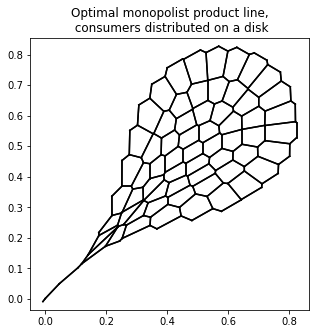

In [41]:
plt.figure(figsize=[5,5])
plt.title("Optimal monopolist product line,\n consumers distributed on a disk")
show_u(sol,X)

**Failed optimization attempt with `trust-constr`**

<!---

def NonlinearConstraint(f,fargs):
    """
    Represents the constraint : np.bincount(indices,weights) >= 0,
    where (indices, weights) = f(x,*fargs)
    (Indices may be repeated, and the associated values must be summed.)
    """
    def fun(x):
        ind,wei = f(x,*fargs)
        return np.bincount(ind,wei)
    def grad(x): 
        ind,wei = f(ad.Sparse.identity(constant=x),*fargs)
        triplets = (wei.coef.reshape(-1),(ind.repeat(wei.size_ad),wei.index.reshape(-1)))
        return scipy.sparse.coo_matrix(triplets).tocsr()
    def hess(x,v): # v is a set of weights, provided by the optimizer
        ind,wei = f(ad.Sparse2.identity(constant=x),*fargs)
        return np.sum(v[ind]*wei).hessian_operator()
    return sciopt.NonlinearConstraint(fun,0.,np.inf,jac=grad,hess=hess,keep_feasible=True)

# -----------------

X = 0.2*disk_X(5) + 0.5 # Unit disk, centered at (2,2)
T = Delaunay(X)
u_guess = 0.5*(X[0]**2+X[1]**2) # Strictly convex guess

u_ad2 = ad.Sparse2.identity(constant=np.zeros_like(u_guess))
obj = QuadraticObjective_AD(monopolist_objective(u_ad2,X,T) )

def convexity_constraint(u,X):
    try: #return SubgradientMeasures(*FacetGradients(u,X),1)
        S,Sm = SubgradientMeasures(*FacetGradients(u,X),1)
        return S,100*Sm
    except ValueError: return np.arange(len(u)),np.full(len(u),-1.)
    
nlcons = NonlinearConstraint(convexity_constraint,(X,))

# --------------------

#%%time
sol = sciopt.minimize(x0=u_guess,method='trust-constr',
    **obj,
    constraints = [nlcons], #
    bounds = sciopt.Bounds(0.,np.inf),options={'verbose':1,'maxiter':600})

print([obj['fun'] (z) for z in (u_guess,sol.x)]) # decreases ??

plt.figure(figsize=[5,5]) # Expected shape ??
S,N,Sint,Sg = FacetGradients(sol.x,X)
plt.scatter(*Sg)
plt.axis('equal');

--->

### 3.4 Non-uniformly convex domain

In [42]:
def interior_subgradients_line(u,X):
    """Similar to interior_subgradients, except that u is defined 
    over a family of *aligned* but unordered points X."""
    v = X[:,0]-X[:,1]; v /= np.linalg.norm(v) # Find the line direction
    X = lp.dot_VV(X,v[:,None]) # Compute the points abcissa
    ai = np.argsort(X) # Reorder
    X = X[ai]; u=u[ai]
    Sm = interior_subgradients(u,X) # Subgradient measures, 1D code
    ρ = avg(diff(X)) # Weight function
    return - np.sum(ρ*np.log(Sm))
    
    
def objective(u,X,DX,T,λ0,λ1,λ2,**kwargs):
    return objective_uconv(u,X,T,λ0,λ1,**kwargs) \
        + λ2*sum(interior_subgradients_line(u[F],X[:,F]) for F in DX)  

In [43]:
X,DX = square_X(10)
T=Delaunay(X)
X1 = 1+X
X2 = 1.5+lp.dot_AV(lp.rotation(np.pi/4)[:,:,None],X-0.5)
def quad(X): return 0.5*(X[0]**2+X[1]**2) # Dummy convex funciton

In [44]:
%%time
sol1 = ad.Optimization.newton_minimize(objective,quad(X1),(X1,DX,T,0.01,0.01,0.001),step_min = 0.0001)

Initialization, objective 0.021335005660464323


/Users/mirebeau/Dropbox/Programmes/Github/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:43: RuntimeWarning: invalid value encountered in log
  def log(x):	y=1./x; return (np.log(x),y,-y**2)


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Iteration 1, Newton step 0.00390625, objective -0.8065060747378304.


Iteration 2, Newton step 0.001953125, objective -0.8967836497221306.


Iteration 3, Newton step 0.001953125, objective -0.9515783707734139.


Iteration 4, Newton step 0.001953125, objective -0.9698238754680881.


Iteration 5, Newton step 0.00390625, objective -0.9755941979067989.


Iteration 6, Newton step 0.0078125, objective -0.9832993756525432.


Iteration 8, Newton step 0.03125, objective -1.023596276497147.


Iteration 10, Newton step 0.125, objective -1.1747507004297872.


Iteration 12, Newton step 0.03125, objective -1.2081214129381739.


Iteration 14, Newton step 0.125, objective -1.2704464441736527.


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


Iteration 16, Newton step 0.125, objective -1.3571514374498088.


Iteration 20, Newton step 1.0, objective -1.4640518988957456.


Iteration 24, Newton step 1.0, objective -1.4683237983407287.


Convergence criterion satisfied, terminating.
Iteration 28, Newton step 1.0, objective -1.4683240240627677.
CPU times: user 45.4 s, sys: 798 ms, total: 46.2 s
Wall time: 39.2 s


In [45]:
%%time
sol2 = ad.Optimization.newton_minimize(objective,quad(X2),(X2,DX,T,0.01,0.01,0.001),step_min = 0.0001)

Initialization, objective 0.02132684403943591


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Iteration 1, Newton step 0.00390625, objective -0.8208427543339621.


Iteration 2, Newton step 0.0078125, objective -1.260151897064709.


Iteration 3, Newton step 0.015625, objective -1.2848047656192387.


Iteration 4, Newton step 0.03125, objective -1.2933757408499496.


Iteration 5, Newton step 0.0625, objective -1.308806870841307.


Iteration 6, Newton step 0.125, objective -1.3345738066485004.


Iteration 8, Newton step 0.25, objective -1.398310662861263.


Iteration 10, Newton step 1.0, objective -1.4665347792203143.


Iteration 12, Newton step 1.0, objective -1.4773455120328294.


Iteration 14, Newton step 1.0, objective -1.4773455180286688.


Convergence criterion satisfied, terminating.
Iteration 16, Newton step 1.0, objective -1.477345518028669.
CPU times: user 24.8 s, sys: 453 ms, total: 25.2 s
Wall time: 21.6 s


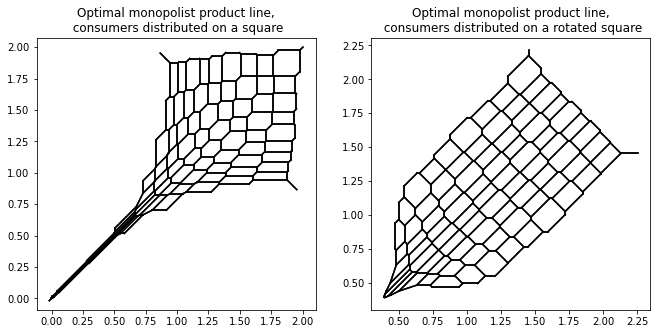

In [46]:
plt.figure(figsize=[11,5])

plt.subplot(121); 
plt.title("Optimal monopolist product line,\n consumers distributed on a square");
show_u(sol1,X1)

plt.subplot(122); 
plt.title("Optimal monopolist product line,\n consumers distributed on a rotated square");
show_u(sol2,X2)

In [47]:
X,DX = triangle_X(10)
T=Delaunay(X)
X1 = 1+ 0.7*lp.dot_AV(lp.rotation(np.pi/4)[:,:,None],X)
X2 = 1+ 0.7*lp.dot_AV(lp.rotation(np.pi/4-np.pi/3)[:,:,None],X)

In [48]:
%%time
sol1 = ad.Optimization.newton_minimize(objective,quad(X1),(X1,DX,T,0.01,0.01,0.001),step_min = 0.0001)

Initialization, objective 0.018415709707352526


/Users/mirebeau/Dropbox/Programmes/Github/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:43: RuntimeWarning: invalid value encountered in log
  def log(x):	y=1./x; return (np.log(x),y,-y**2)


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Iteration 1, Newton step 0.0078125, objective -0.18528731552021108.


Iteration 2, Newton step 0.015625, objective -0.31795318899562264.


Iteration 3, Newton step 0.015625, objective -0.3290278691751811.


Iteration 4, Newton step 0.03125, objective -0.3372893868151492.


Iteration 5, Newton step 0.0625, objective -0.3431631782283434.


Iteration 6, Newton step 0.125, objective -0.3522332625963088.


Iteration 8, Newton step 0.5, objective -0.3808599626586719.


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


Iteration 10, Newton step 1.0, objective -0.39569294335070115.


Iteration 12, Newton step 1.0, objective -0.39796922825961956.


Iteration 14, Newton step 1.0, objective -0.39796922999163575.


Convergence criterion satisfied, terminating.
Iteration 16, Newton step 0.5, objective -0.3979692299916357.
CPU times: user 16.8 s, sys: 421 ms, total: 17.2 s
Wall time: 13.4 s


In [49]:
%%time
sol2 = ad.Optimization.newton_minimize(objective,quad(X2),(X2,DX,T,0.01,0.01,0.001),step_min = 0.0001)

Initialization, objective 0.018518821260304817


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Iteration 1, Newton step 0.00390625, objective -0.06312327903629611.


Iteration 2, Newton step 0.00390625, objective -0.1093586177990498.


Iteration 3, Newton step 0.00390625, objective -0.13376842542503625.


Iteration 4, Newton step 0.00390625, objective -0.1410787453124801.


Iteration 5, Newton step 0.0078125, objective -0.14694456436687744.


Iteration 6, Newton step 0.015625, objective -0.1550315085671805.


Iteration 8, Newton step 0.0625, objective -0.19926852485113888.


Iteration 10, Newton step 0.0625, objective -0.24879998790661575.


Iteration 12, Newton step 0.25, objective -0.3102062881813852.


Iteration 14, Newton step 0.5, objective -0.35483877843590983.


Iteration 16, Newton step 1.0, objective -0.37256470932408914.


Iteration 20, Newton step 1.0, objective -0.37452920708491194.


Convergence criterion satisfied, terminating.
Iteration 23, Newton step 1.0, objective -0.3745292070866183.
CPU times: user 23.2 s, sys: 642 ms, total: 23.9 s
Wall time: 18 s


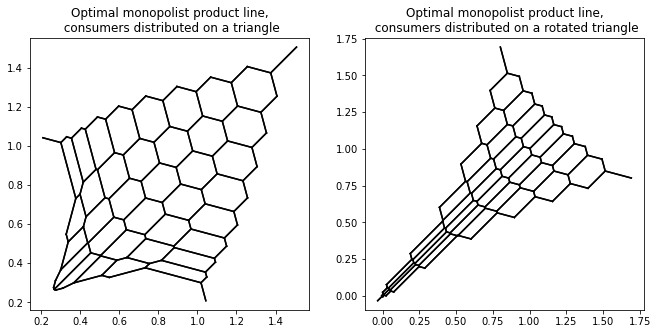

In [50]:
plt.figure(figsize=[11,5])
plt.subplot(121)
plt.title("Optimal monopolist product line,\n consumers distributed on a triangle");
show_u(sol1,X1)

plt.subplot(122) 
plt.title("Optimal monopolist product line,\n consumers distributed on a rotated triangle");
show_u(sol2,X2)

**Performance analysis.**
The computation time is dominated by the AD methods, which are indeed a bit slow, yet the room for improvement limited due to the linear solves.

In [51]:
%%time
u = quad(X2)
obj = objective(u,X2,DX,T,0.01,0.01,0.001)

CPU times: user 4.47 ms, sys: 859 µs, total: 5.33 ms
Wall time: 4.93 ms


In [52]:
%%time
sol2_ad = ad.Sparse2.identity(constant=u)
obj_ad = objective(sol2_ad,X2,DX,T,0.01,0.01,0.001);

CPU times: user 496 ms, sys: 18.8 ms, total: 514 ms
Wall time: 313 ms


In [53]:
%%time
step = obj_ad.solve_stationnary();

CPU times: user 129 ms, sys: 1.55 ms, total: 131 ms
Wall time: 131 ms


## 4. Two dimensional, linear, monopolist

In this section, we constrain the product line of the monopolist within a given convex polygonal region $Y$.
This can be implemented in several ways:
- (Finite element approach) Estimate the gradients using the finite element method, and constrain them within $Y$.
- (Subgradient approach) Compute the subgradients associated with the boundary cells, and require that their intersection with $Y$ has positive area.

Both approaches are consistent. The first one is easier to implement, whereas the second one is more in the spirit of this notebook.

### 4.1 Finite element approach

This approach amounts to linear constraints since:
- the convex polygonal region $Y$ can be regarded as a finite intersection of half-spaces.
- the finite element gradients have linear components.

**Should we constrain the gradients associated to interior triangles ?**
There is no definite answer to this question. On the one hand, since the solution $u$ is convex, its gradient can only be extremal on the domain boundary, which suggests discarding the gradients associated to interior triangles.
On the other hand, the discretized unknown $u$, yields a non-convex function when interpolated on the finite element triangulation (although there exists a triangulation onto which the interpolation is convex).

In [54]:
def det(u,v): return u[0]*v[1]-u[1]*v[0]
def gradient_constraints(u,X,T,Y):
    """Y lists the vertices, counter-clockwise, of the given convex region. 
    (Repeat the endpoint for a bounded region.*)"""
    g = gradientFE(u,X,T)
    dY = np.roll(Y,-1,axis=1)-Y
    gY = g[:,None]-Y[:,:,None]
    return det(dY[:,:,None],gY)

def boundary_triangulation(T,DX):
    """Keep only triangles containing a boundary vertex."""
    if np.ndim(DX)>1: DX = np.logical_or.reduce(DX,axis=0) # Gather all boundary faces
    return T[:,np.logical_or.reduce(DX[T],axis=0)]

In [55]:
nX=11
X,DX = square_X(nX-1)
T = Delaunay(X)
Tbd = boundary_triangulation(T,DX)
Y = np.array([(1,0),(1,1),(0,1),(0,0)]).T
def guess(X): return 0.1+0.25*((X[0]**2+X[1]**2)+X[0]+X[1])

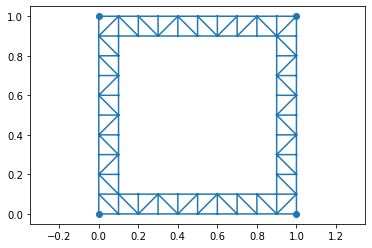

In [56]:
plt.triplot(*X,Tbd.T)
plt.scatter(*Y)
plt.axis('equal');

In [57]:
def objective_YFE(u,X,DX,T,Tbd,Y,λ0,λ1,λ2,λ3):
    """Objective function where the gradient
    is constrained within a set Y"""
    ρbd = cellmeasFE(X,Tbd)
    return objective(u,X,DX,T,λ0,λ1,λ2,quadratic=False) \
        -λ3*np.sum(ρbd*np.log(gradient_constraints(u,X,Tbd,Y)))

In [58]:
%%time
sol = ad.Optimization.newton_minimize(objective_YFE,guess(X),(X,DX,T,Tbd,Y,0.01,0.01,0.001,0.001),step_min = 0.0001)

Initialization, objective -0.021317362821699434


/Users/mirebeau/Dropbox/Programmes/Github/AdaptiveGridDiscretizations/agd/AutomaticDifferentiation/Base.py:43: RuntimeWarning: invalid value encountered in log
  def log(x):	y=1./x; return (np.log(x),y,-y**2)


/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:206: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)
/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/mirebeau/opt/miniconda3/envs/agd-hfm_dev/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


Iteration 1, Newton step 0.00390625, objective -0.08348597981683419.


Iteration 2, Newton step 0.00390625, objective -0.11963657250280649.


Iteration 3, Newton step 0.00390625, objective -0.13786512510388116.


Iteration 4, Newton step 0.0078125, objective -0.1620544379140475.


Iteration 5, Newton step 0.015625, objective -0.2105725274235191.


Iteration 6, Newton step 0.015625, objective -0.25428365539508146.


Iteration 8, Newton step 0.0625, objective -0.38506952987162574.


Iteration 10, Newton step 0.125, objective -0.43253859750717805.


Iteration 12, Newton step 0.25, objective -0.45100900217990153.


Iteration 14, Newton step 1.0, objective -0.45913368134409543.


Iteration 16, Newton step 1.0, objective -0.4595992503551368.


Iteration 20, Newton step 1.0, objective -0.459617838296294.


Convergence criterion satisfied, terminating.
Iteration 21, Newton step 0.5, objective -0.4596178382962939.
CPU times: user 41 s, sys: 1.1 s, total: 42.1 s
Wall time: 30.9 s


This specific problem is known to have an explicit solution, which is piecewise linear, and whose gradients are the extreme points $(0,0),(1,0),(0,1),(1,1)$ of the set $Y$. 

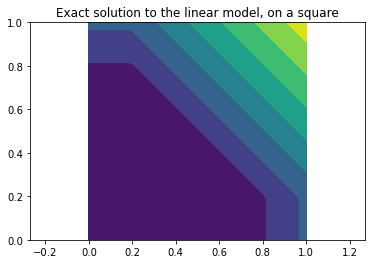

In [59]:
def exact_sol(x,y):
    """Exact solution for the linear monopolist model, 
    with uniform density over a square."""
    a=2/3; b=(4-np.sqrt(2))/3
    return np.maximum.reduce((0*x,x-a,y-a,x+y-b))

aX = np.linspace(0,1)
X0 = np.array(np.meshgrid(aX,aX,indexing='ij'))

plt.title("Exact solution to the linear model, on a square")
plt.contourf(*X0,exact_sol(*X0))
plt.axis('equal');

Due to the coarse grid size, and the inaccuracies introduced by the numerical method, we only obtain some approximation.

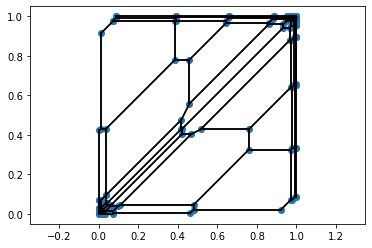

In [60]:
show_u(sol,X,scatter=True) # Gradients are expected to concentrate in the corners.

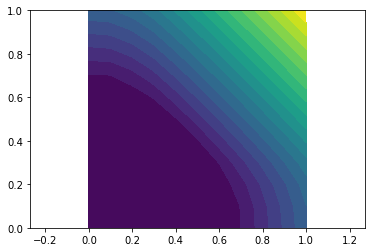

In [61]:
# Somehow approximates the exact solution, which is piecewise linear
plt.contourf(*X.reshape(2,nX,nX),sol.reshape(nX,nX),levels=20)
plt.axis('equal');

### 4.2 Intersected subgradient approach (*TODO*)